In [64]:
import os
import tarfile
import urllib
from zlib import crc32
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = 'datasets/housing/'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [3]:
HOUSING_URL

'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'

In [4]:
DOWNLOAD_ROOT + HOUSING_PATH

'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/'

In [5]:
# descarga los datos de la URL en el repo de Github (la URL solo debe contener /)
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [6]:
#  Carga el archivo .csv que fue descargado (el path debe contener barras o barras invertidas dependiendo del S.O)
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [7]:
# Ver data
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
# Descripcion de la data 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
# Numero de categorias de distrito (unico tipo object del conjunto de datos)
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [10]:
# Resumen de los atributos numericos
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


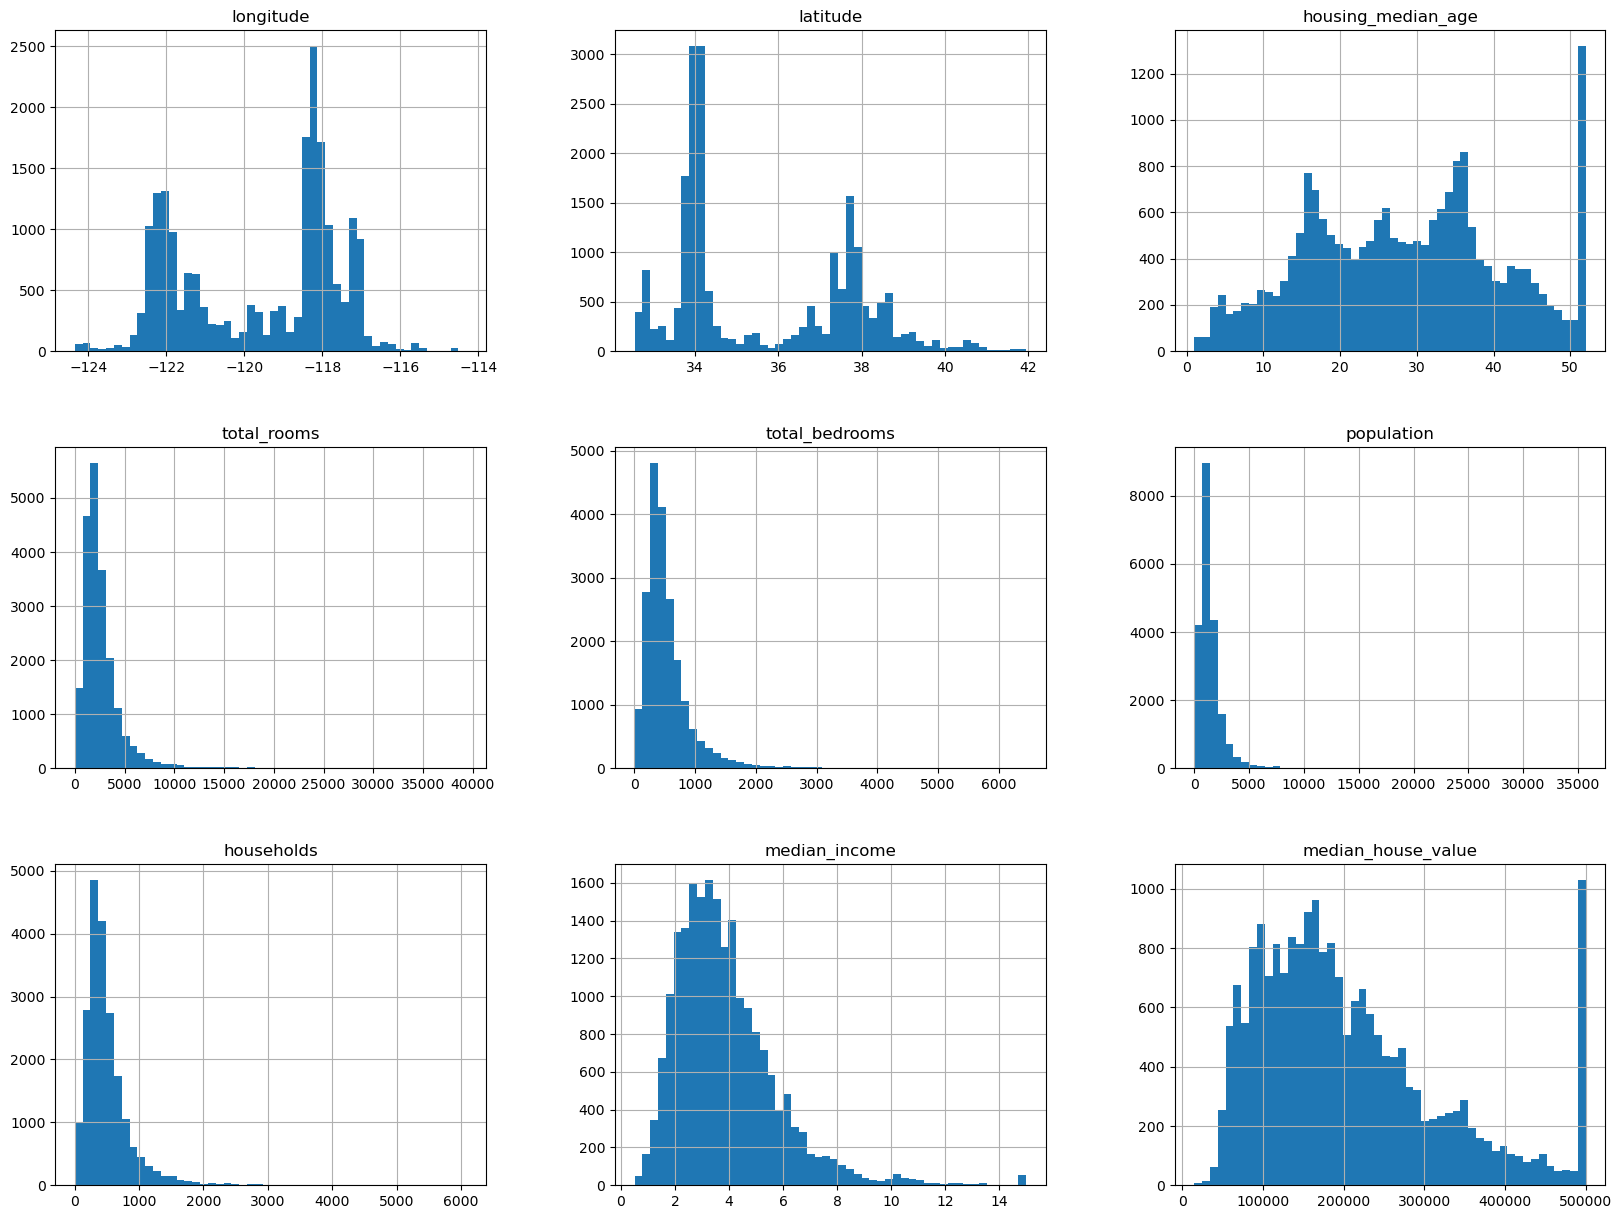

In [11]:
# plots (histogramas) para cada tipo de dato numerico
housing.hist(bins = 50, figsize = (20, 15))

plt.show()

In [12]:
# funcion de separacion de conjuntos de datos
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
# obtenemos los conjuntos de entrenamiento y testeo
train_set, test_set = split_train_test(housing, 0.2)

In [14]:
print(f'El conjunto de entrenamiento tiene: {len(train_set)} datos \nEl conjunto de testeo tiene: {len(test_set)} datos')

El conjunto de entrenamiento tiene: 16512 datos 
El conjunto de testeo tiene: 4128 datos


In [15]:
# Funciones para que se contengan instancias de nuevos conjuntos de datos 
# (por ej. 20% de las nuevas instancias seran incluidas en el conjunto de testo,
# pero no va a contener ninguna instancia que previamente haya estado en el conjunto de entrenamiento

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    ## ~ cambiar el valor de verdad en la serie
    return data.loc[~in_test_set], data.loc[in_test_set]

In [16]:
# El conjunto de datos housing no tiene un identificador comun (columna)
# Usaremos el index como id
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [17]:
# Categoria de ingresos 
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins = [0, 1.5, 3, 4.5, 6, np.inf],
                              labels = [1, 2, 3, 4, 5])

<Axes: >

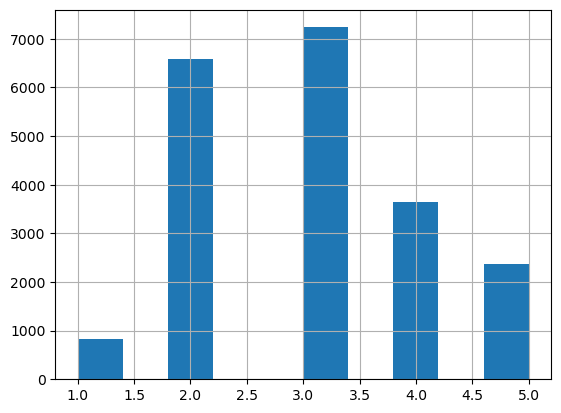

In [18]:
# Distribucion categorica del ingreso
housing['income_cat'].hist()

In [19]:
# Muestro estratificado basado en la categoria de ingreso (con sklearn)
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
income_category_proportions = strat_test_set['income_cat'].value_counts()/len(strat_test_set)

income_category_proportions

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [21]:
# Removemos la categoria de ingreso para que los datos vuelvan a su estado original
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Exploración de los datos

In [22]:
# Copiamos el conjunto de entrenamiento para descubrir tendencias y visualizar los datos
housing = strat_train_set.copy()

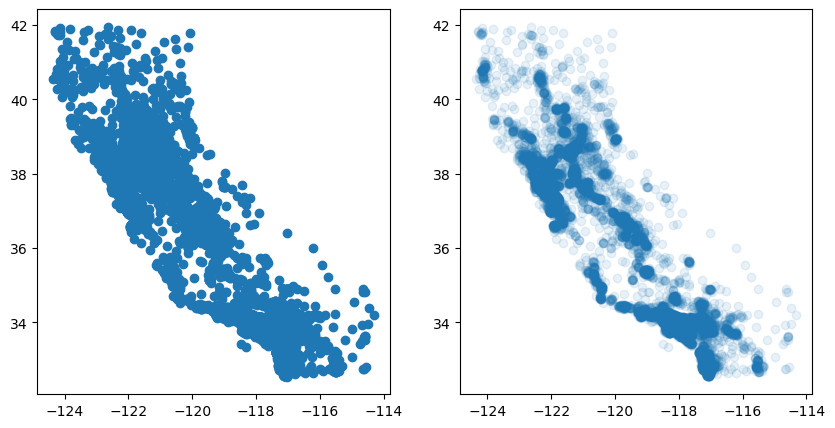

In [23]:
# Visualicemos los datos a través de la longitud y la latitud de los distritos
# Crearemos dos plots en una fig
# Asignando 0.1 a alpha podemos ver dónde hay una mayor densidad de puntos

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

data1=np.array(housing['longitude'])
data2=np.array(housing['latitude'])

ax1.scatter(data1,data2)
ax2.scatter(data1,data2, alpha=0.1)

#ax1 = housing.plot(kind='scatter', x='longitude', y='latitude')
#ax2 = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

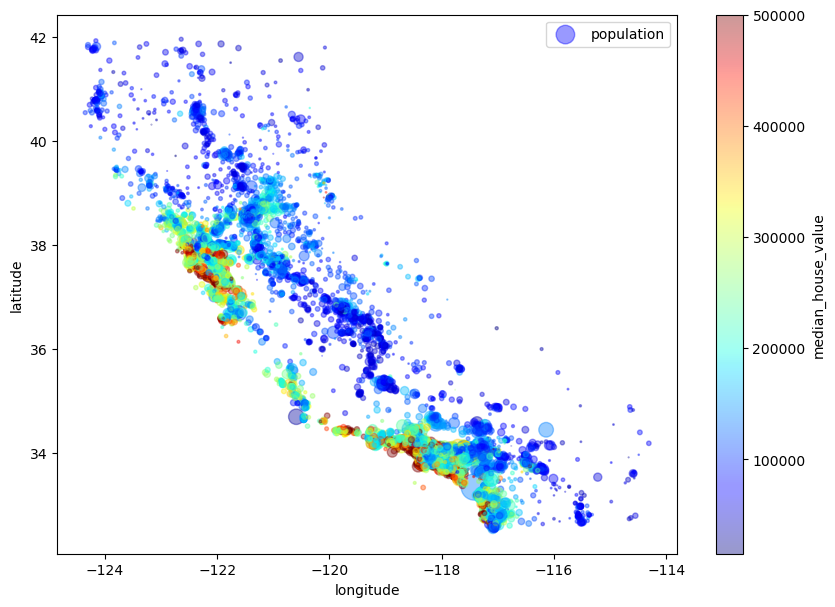

In [24]:
# Visualizar los precios de las casas de los distritos
# Usaremos un colormap predefinido "jet" que va desde el azul (valores bajos) a rojo (valores altos)
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()

In [25]:
# Coeficiente de correlacion estandar (r de Pearson)
# Utilizamos el método drop para quitar la proximidad al oceano de la matriz de correlacion (atributo categorico)
corr_matrix = housing.drop('ocean_proximity', axis=1).corr()

corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [26]:
# Correlacion de cada atributo con el valor medio de la casa
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

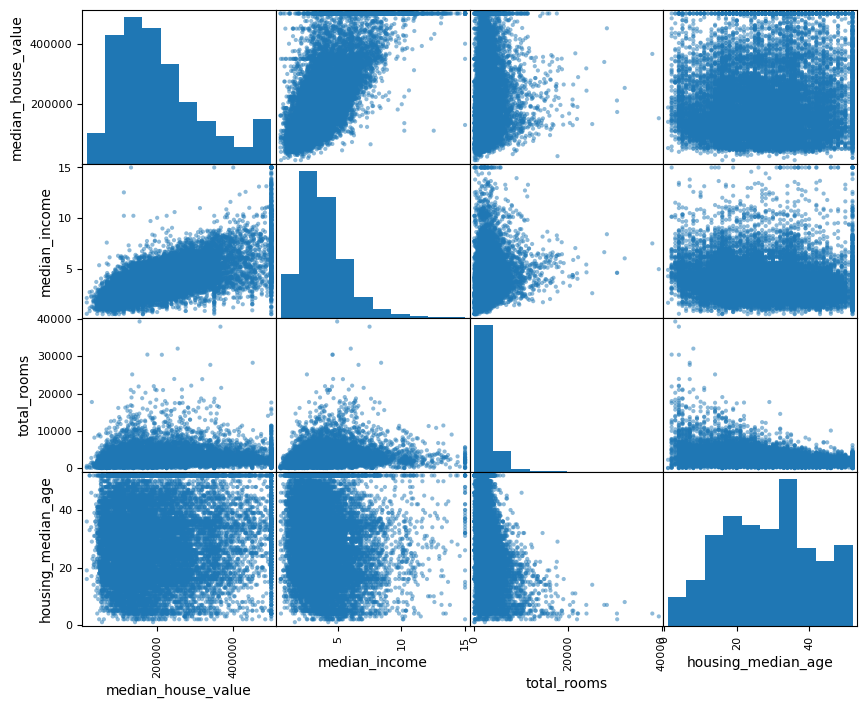

In [27]:
# Plots de correlacion de los atributos mas importantes (los mas correlacionados con el valor medio de la casa)
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(10,8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

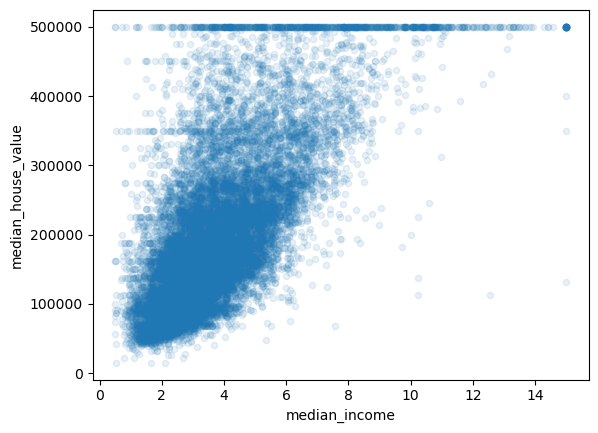

In [28]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [29]:
# Crearemos nuevos atributos para analizar
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']=housing['population']/housing['households']

In [30]:
# Volvamos a ver la matriz de correlacion con estos atributos nuevos
corr_matrix = housing.drop('ocean_proximity', axis=1).corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Preparando los datos para un algoritmo de ML

In [31]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data cleaning

In [32]:
# total_bedrooms es un atributo al que le faltan valores
# rellenaremos los faltantes con un valor (en este caso la media a través de la clase simpleImputer)
# Instanciamos
imputer = SimpleImputer(strategy='median')

#Eliminamos el atributo de proximidad al oceano ya que no es numerico (el simpleImputer solo acepta df con atributos numericos)
housing_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [33]:
# El imputer hizo computo de la media de cada atributo y lo guarda en una variable de instancia statistics_
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [34]:
# Transformamos el conjunto de entrenamiento reemplazando los faltantes por su media
X = imputer.transform(housing_num)

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) 

In [36]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### Atributos categoricos

In [37]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [38]:
# Convertir los tipos categoricos a numericos
# One hot encoding: un atributo vale 1 (hot) mientras los otros valen 0 (cold). Los nuevos atributos son dummies
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [39]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Reescalado de datos

### Transformers personalizados

In [40]:
# Clase transformer que agrega atributos combinados
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributedAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

### Pipelines

In [41]:
# Pipeline para los atributos numericos
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                         ('attribs_adder', CombinedAttributedAdder()),
                        ('std_scaler', StandardScaler())])

In [42]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [43]:
# Usaremos un solo transformer para todos los atributos (tanto numericos como categoricos)
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                  ('cat', OneHotEncoder(), cat_attribs),])

housing_prepared = full_pipeline.fit_transform(housing)

## Entrenamiento de modelo

In [44]:
# Modelo de regresion lineal
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [45]:
# Probando predicciones (resultado no muy bueno)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))
print('labels:', list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [46]:
# Error cuadratico medio del modelo
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print('El error cuadratico medio del modelo de regresion lineal es:', lin_rmse)

El error cuadratico medio del modelo de regresion lineal es: 68627.87390018745


In [47]:
# Probando un modelo mas complejo (para intentar solucionar)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [48]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmsq = np.sqrt(tree_mse)

print('El error cuadratico medio con el modelo de arbol de decision es:', tree_rmsq)

El error cuadratico medio con el modelo de arbol de decision es: 0.0


In [49]:
# Validacion cruzada utilizando sklearn
scores = cross_val_score(tree_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error', 
                         cv=10)
tree_rmse_score = np.sqrt(-scores)

In [50]:
tree_rmse_score

array([73177.56046996, 70582.01706587, 67187.19324905, 72851.85847087,
       70629.6809291 , 75202.50594546, 72242.21999562, 74361.86139553,
       66856.79631122, 71778.4384357 ])

In [51]:
def display_scores(scores):
    print('Scores:', scores)
    print('Media de scores:', scores.mean())
    print('Desvio estandar de scores:', scores.std())

display_scores(tree_rmse_score)

Scores: [73177.56046996 70582.01706587 67187.19324905 72851.85847087
 70629.6809291  75202.50594546 72242.21999562 74361.86139553
 66856.79631122 71778.4384357 ]
Media de scores: 71487.0132268374
Desvio estandar de scores: 2625.39623332618


In [52]:
# Comparacion model de arbol de decision y regresion lineal
lin_scores = cross_val_score(lin_reg, 
                             housing_prepared, 
                             housing_labels, 
                             scoring='neg_mean_squared_error', 
                             cv=10)
lin_rmse_score = np.sqrt(-lin_scores)

display_scores(lin_rmse_score)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Media de scores: 69104.07998247063
Desvio estandar de scores: 2880.328209818067


In [53]:
# Modelo Random Forest Regressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [54]:
forest_scores = cross_val_score(forest_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error', 
                         cv=10)
forest_rmse_score = np.sqrt(-forest_scores)

In [55]:
display_scores(forest_rmse_score)

Scores: [51231.18899945 49021.74195571 47154.71593296 51704.97603491
 47269.72796421 51895.68128076 52822.03890091 49493.22200702
 48582.03061103 53788.23286877]
Media de scores: 50296.35565557347
Desvio estandar de scores: 2196.069192116267


## Ajuste de modelo

In [56]:
# Buscar la mejor combinacion de hiperparametros para este modelo a traves de GridSearchCV

#El param_grid indica a scikit-learn que primero evalue las 12 combinaciones (3 x 4) posibles 
#entre n_estimators y max_features especificados en el primer diccionario. Luego hace lo mismo
#con el segundo diccionario probando las 6 combinaciones (2 x 3) posibles pero esta vez 
#con el hiperparametros bootstrap seteado en False en vez de True
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
    ]

forest_reg = RandomForestRegressor()

#grid_search explora las 18 combinaciones (12 + 6) posibles de valores de hiperparametro
#en RandomForestRegressor y entrena cada modelo 5 veces, resultando en 90 rondas de entrenamiento
#(18 x 5)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [57]:
#Mejor combinacion de parametros
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [58]:
#Scores de evaluacion
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63909.82016656952 {'max_features': 2, 'n_estimators': 3}
55271.00671677809 {'max_features': 2, 'n_estimators': 10}
52830.36497409042 {'max_features': 2, 'n_estimators': 30}
60655.414638107664 {'max_features': 4, 'n_estimators': 3}
52744.77795599312 {'max_features': 4, 'n_estimators': 10}
50479.4722779565 {'max_features': 4, 'n_estimators': 30}
59017.41715466121 {'max_features': 6, 'n_estimators': 3}
52290.717996408945 {'max_features': 6, 'n_estimators': 10}
49875.736361586416 {'max_features': 6, 'n_estimators': 30}
59634.32822270525 {'max_features': 8, 'n_estimators': 3}
52069.664489030125 {'max_features': 8, 'n_estimators': 10}
49930.05777241581 {'max_features': 8, 'n_estimators': 30}
61913.50479570241 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54062.68291826266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58587.84087541166 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52210.319727389906 {'bootstrap': False, 'max_features': 3, 'n_estimators'

## Analisis de los mejores modelos y sus errores

In [59]:
#RandomForestRegressor puede indicar la importancia relativa de cada atributo
#para realizar predicciones precisas

feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

array([7.65216778e-02, 6.80194030e-02, 4.21056060e-02, 1.70616189e-02,
       1.66889116e-02, 1.74414253e-02, 1.59904716e-02, 3.39833527e-01,
       5.39558280e-02, 1.06755932e-01, 6.99879446e-02, 9.10808061e-03,
       1.61031260e-01, 5.41364218e-05, 1.83257976e-03, 3.61159772e-03])

In [60]:
# Mostrar los scores con su correspondiente atributo
extra_attribs = ['rooms_per_hold', 'pop_per_hold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs 
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33983352667547456, 'median_income'),
 (0.16103125963868264, 'INLAND'),
 (0.10675593233192343, 'pop_per_hold'),
 (0.07652167777510052, 'longitude'),
 (0.06998794464113665, 'bedrooms_per_room'),
 (0.06801940301720504, 'latitude'),
 (0.05395582797568765, 'rooms_per_hold'),
 (0.04210560599702061, 'housing_median_age'),
 (0.017441425330723574, 'population'),
 (0.017061618884029447, 'total_rooms'),
 (0.01668891164263859, 'total_bedrooms'),
 (0.015990471572144917, 'households'),
 (0.009108080611172574, '<1H OCEAN'),
 (0.003611597720888966, 'NEAR OCEAN'),
 (0.0018325797643356716, 'NEAR BAY'),
 (5.4136421835108014e-05, 'ISLAND')]

## Evaluación del sistema (en el conjunto de testeo)

In [63]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f'El RMSE es {final_rmse}')

El RMSE es 47679.8021745721


In [65]:
# Aplicando intervalo de confianza para la generalización del error
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45699.91213574, 49580.69283096])